# Polarity and lexical complexity to study social topics in music genres

## Goals

This work aims at conducting a sentiment analysis through music genres. There are many ways to complete this goal, however it is important that the parameters and analysers we use are fitting our data. Sentiment analysis is a very large field, and we believe that we used the librairies and functions that are the most appropriate for the chosen dataset. 
This work can be divided into 4 parts:
 1. Data imports: structures, sorting and wrangling
 2. Classifiers: Choosing the methods of analysis and extracting features
 3. Visualization: How to meaningfully represent the data
 4. Finalization: Organization of the outputs
 
 
##### Dataset credits:
musiXmatch dataset, the official lyrics collection for the Million Song Dataset, 
available at: http://labrosa.ee.columbia.edu/millionsong/musixmatch

In [61]:
#Importing libraries
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import re
import nltk
import scipy
import sklearn
import sklearn.preprocessing
import gensim as gs
import pylab as pl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display, Image
from nltk.corpus import stopwords
import nltk
import os

# internal imports
import helpers as HL


# Constants: PS! put in your own paths to the files
GLOVE_FOLDER = 'glove.twitter.27B'
GS_FOLDER = os.path.abspath("doesnt_matter" + "/../../../../" + "Machine_Learning/CD-433-Project-2/gensim_data_folder/") #PS: this is only in my folderstructuree
GS_25DIM = GS_FOLDER + "/gensim_glove_vectors_25dim.txt"
GS_50DIM = GS_FOLDER + "/gensim_glove_vectors_50dim.txt"
GS_100DIM = GS_FOLDER + "/gensim_glove_vectors_100dim.txt"
GS_200DIM = GS_FOLDER + "/gensim_glove_vectors_200dim.txt"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Data imports: structures, sorting and wrangling
- Import the Songs Titles and Artists from MusiXMatch  779052 songs  
- Import the Year from million song additional files   498466 songs
- Import the Genres from TagTraum  255015 songs    
- Import the lyrics & the bag of words 91625 songs


## 1.1. Importing the songs
For now we only use titles and artist names, we are able to handle this part with only the musixmatch website. We download the data and put it into a dataframe with the Id of MusiXMatch(MXM_Tid) and the Track ID of the Million Song DataSet(Tid). Because we might have data that is given with one classification or the other, we decide to keep the two IDs, but we are fully aware that having two IDs is not giving additional information, it is only to be sure that other datasets will be easier to merge.   
We for now, we get 779052 song's artists and titles

In [2]:
#Importing the text file in a DataFrame, removing exceptions (incomplete data)
matches = pd.read_table('Data/mxm_779k_matches.txt', error_bad_lines=False)

#Changing the column's title in order to be clearer
matches.columns = ['Raw']

#Getting the Tid
matches['Tid'] = matches['Raw'].str.split('<SEP>', expand=True)[0]

#Extracting artist names
matches['Artist_Name'] = matches['Raw'].str.split('<SEP>', expand=True)[1]

#Extracting titles
matches['Title'] = matches['Raw'].str.split('<SEP>', expand=True)[2]

#Extractign MXM_Tid
matches['MXM_Tid'] = matches['Raw'].str.split('<SEP>', expand=True)[3]

#Dropping rows we do not need ()
matches = matches.drop(matches.index[:17])

#Droppign the column with raw data
matches = matches.drop('Raw', axis=1)

#set index Track ID
matches.set_index('Tid',inplace=True)

#Displaying results
display(matches.shape)
display(matches.head())

b'Skipping line 60821: expected 1 fields, saw 2\nSkipping line 126702: expected 1 fields, saw 2\n'
b'Skipping line 580629: expected 1 fields, saw 2\nSkipping line 632526: expected 1 fields, saw 2\n'


(779052, 3)

,Artist_Name,Title,MXM_Tid
Tid,,,
TRMMMKD128F425225D,Karkkiautomaatti,Tanssi vaan,4418550
TRMMMRX128F93187D9,Hudson Mohawke,No One Could Ever,8898149
TRMMMCH128F425532C,Yerba Brava,Si Vos Querés,9239868
TRMMMXN128F42936A5,David Montgomery,"Symphony No. 1 G minor ""Sinfonie Serieuse""/All...",5346741
TRMMMBB12903CB7D21,Kris Kross,2 Da Beat Ch'yall,2511405


##### Remarks:
- There are two distinct identifiers for the same data. Because we might have data that is given with one classification or the other, we decide to keep the two IDs, but we are fully aware that having two IDs is not giving additional information, it is only to be sure that other datasets will be easier to merge.
- This is only containing the artist and title, we need further informations such as the genre and the bags of words for each song. 

## 1.2. Extracting the Year of the songs

We download the text file from the "A million song" website. It is provided as an additional feature of the dataset.  
We merge the year dataset with the artists and song titles in the same dataframe.

In [3]:
#Loading the year of publication data, skipping incomplete data in order to avoid errors
years = pd.read_table('Data/tracks_per_year.txt', error_bad_lines=False)
#Changing the column's title in order to be clearer
years.columns = ['Raw']

#Getting the year publication
years['year'] = years['Raw'].str.split('<SEP>', expand=True)[0]

#Getting the Tid
years['Tid'] = years['Raw'].str.split('<SEP>', expand=True)[1]

#Dropping the raw data
years = years.drop('Raw', axis=1)

#set index Track ID
years.set_index('Tid',inplace=True)

#Appending the years to the original DataFrame
matches = pd.merge(matches, years, left_index=True, right_index=True)

b'Skipping line 487582: expected 1 fields, saw 2\nSkipping line 487590: expected 1 fields, saw 2\n'


In [4]:
#display the results
print(matches.shape)
display(matches.head())

(498466, 4)


,Artist_Name,Title,MXM_Tid,year
Tid,,,,
TRMMMKD128F425225D,Karkkiautomaatti,Tanssi vaan,4418550,1995
TRMMMRX128F93187D9,Hudson Mohawke,No One Could Ever,8898149,2006
TRMMMCH128F425532C,Yerba Brava,Si Vos Querés,9239868,2003
TRMMMBB12903CB7D21,Kris Kross,2 Da Beat Ch'yall,2511405,1993
TRMMMNS128F93548E1,3 Gars Su'l Sofa,L'antarctique,7503609,2007


#### Remarks:  
We delete the rows without year infos. Thus why the dataframe contains less songs. In order to be able to be as complete as accurate as possible, we consider only full matching.

## 1.3 Importing genres
We will now append each genre to a specific track.  
We download the data from the TagTraum dataset and merge them without our previous dataframe.

In [5]:
#Creating a DataFrame to store the genres:
GenreFrame = pd.read_table('Data/msd-topMAGD-genreAssignment.txt', names=['Tid', 'genre'])

#set index Track ID
GenreFrame.set_index('Tid',inplace=True)

#merge the new datas with the previous dataframe
matches = pd.merge(GenreFrame, matches, left_index=True, right_index=True)

In [6]:
#Displaying results
print(matches.shape)
display(matches.head())

(255015, 5)


,genre,Artist_Name,Title,MXM_Tid,year
Tid,,,,,
TRAAAAK128F9318786,Pop_Rock,Adelitas Way,Scream,8692587,2009
TRAAAAV128F421A322,Pop_Rock,Western Addiction,A Poor Recipe For Civic Cohesion,4623710,2005
TRAAABD128F429CF47,Pop_Rock,The Box Tops,Soul Deep,6477168,1969
TRAAAEF128F4273421,Pop_Rock,Adam Ant,Something Girls,3759847,1982
TRAAAEM128F93347B9,Electronic,Son Kite,Game & Watch,2626706,2004


##### Comment:
The dataframe contains once again less songs. We proceed this way for the same reason as mentioned in the part before.

## 1.4. Importing Location

We download the file with the location of every artist from the additional files

In [7]:
#Creating a DataFrame to store the location:
location = pd.read_csv('Data/artist_location.txt', sep="<SEP>",header=None,names=['ArtistID','Latitude','Longitude','Artist_Name','City'])
#Keep useful datas
location.drop(['ArtistID','City'],inplace=True,axis=1)
 
#matches = pd.merge(location, matches, on='Tid')
matches.reset_index(inplace=True)
matches = pd.merge(location, matches, on='Artist_Name')
matches.set_index('Tid',inplace = True)

/Users/havardbjornoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [8]:
#Displaying results
display(matches.head())
print(matches.shape)

,Latitude,Longitude,Artist_Name,genre,Title,MXM_Tid,year
Tid,,,,,,,
TRBAWHU128EF3563C5,51.59678,-0.33556,Screaming Lord Sutch,Pop_Rock,Murder In The Graveyard,7883403,1982
TREPTTY128EF3563C1,51.59678,-0.33556,Screaming Lord Sutch,Pop_Rock,Penny Penny,2546441,1982
TRJSKEX128EF3563C7,51.59678,-0.33556,Screaming Lord Sutch,Pop_Rock,London Rocker,2546440,1982
TRKCPUR128F92CF37D,51.59678,-0.33556,Screaming Lord Sutch,Pop_Rock,Jack The Ripper,4439345,1982
TRKYESP128EF3563C0,51.59678,-0.33556,Screaming Lord Sutch,Pop_Rock,Monster Rock,2546437,1982


(103401, 7)


## 1.5. Bags of words, extracting them from the train dataset

We downloaded the train datafile which is 30% of the whole dataset.
Inside we have a list of the 5000 words the most used in the ... songs.
We then make two dataframes: 
- One with the Id of every songs and their lyrics. We merge this with our previous dataframe.
     
     The lyrics are presented as follow : [(id of word),(occurence in song)][2,24][5,47]...  


- Another one with the 5000 top words of the songs (Bag of Words)           
            
  
We work with only 30% of the whole dataset because we use the MusicXMatch dataset and it is the only data that are available.  
The rest of the data are not free. You could see that page : https://developer.musixmatch.com/plans to verify.



In [9]:
#import file
lyrics = pd.read_table('Data/mxm_dataset_train.txt', error_bad_lines=False)

#change name of the column
lyrics.columns = ['Raw_Training']

# take the bag of word to use it later
words_train = lyrics.iloc[16]

#drop useless rows
lyrics=lyrics[17:].copy()

# get TrackID, MxMID and lyrics and put them separated columns
def sortdata(x):
    splitted = x['Raw_Training'].split(',')
    x['Tid']=splitted[0]
    #x['MXM_Tid']=splitted[1]
    x['words_freq']=splitted[2:]
    return x

#Apply the function to every column
lyrics = lyrics.apply(sortdata,axis=1)
lyrics = lyrics[['Tid','words_freq']]

In [10]:
#set index Track ID
lyrics.set_index('Tid',inplace=True)

#Appending the years to the original DataFrame
matches = pd.merge(matches, lyrics, left_index=True, right_index=True)

In [11]:
#Displaying the results
print(matches.shape)
display(matches.head())

(38513, 8)


,Latitude,Longitude,Artist_Name,genre,Title,MXM_Tid,year,words_freq
Tid,,,,,,,,
TRAAAAV128F421A322,37.77916,-122.42005,Western Addiction,Pop_Rock,A Poor Recipe For Civic Cohesion,4623710,2005,"[1:6, 2:4, 3:2, 4:2, 5:5, 6:3, 7:1, 8:1, 11:1,..."
TRAAABD128F429CF47,35.14968,-90.04892,The Box Tops,Pop_Rock,Soul Deep,6477168,1969,"[1:10, 3:17, 4:8, 5:2, 6:2, 7:1, 8:3, 9:2, 10:..."
TRAAAEF128F4273421,35.83073,-85.97874,Adam Ant,Pop_Rock,Something Girls,3759847,1982,"[1:5, 2:4, 3:3, 4:2, 5:1, 6:11, 9:4, 12:9, 13:..."
TRAAAHJ128F931194C,39.74001,-104.99226,Devotchka,Pop_Rock,The Last Beat Of My Heart (b-side),5133845,2004,"[1:4, 2:11, 3:2, 4:7, 5:3, 6:5, 8:1, 9:3, 10:6..."
TRAABIG128F9356C56,40.71455,-74.00712,Poe,Pop_Rock,Walk the Walk,678806,2000,"[1:28, 2:77, 3:31, 4:41, 5:5, 6:13, 8:17, 9:5,..."


##### Comments on the size:
Due to the fact that we do not have access to the entire dataset, our analysis is limited to the 30% that is freely available on MusixMatch.

## 1.6. From generic bags of words to lyrics


We Create a function that take the list of the word and the occurency in one song : [(id of word),(occurency in the song)][2,24][5,47]...  
And output all the corresponding words in a list  

For example : [1:2,2:5,3:3] gives us --> [i,i,the,the,the,the,the,you,you,you]

In [12]:
#get the datas
bag_of_words = words_train
# clean the data and split it to create a list of 5000 words
bag_of_words = bag_of_words.str.replace('%','')
bag_of_words = bag_of_words.str.split(',')

display(bag_of_words.head())

Raw_Training    [i, the, you, to, and, a, me, it, not, in, my,...
Name: 16, dtype: object

In [13]:
#Defining a function
def create_text(words_freq):
    #create the final list of all words
    list_words=''
    #iterate over every id of words
    for compteur in words_freq:
        
        word = bag_of_words[0][int(compteur.split(':')[0])-1]
        times = int(compteur.split(':')[1])
        
        #Separating every word with a space to be able to work on it with librairies during part 2
        for i in range(times):
            list_words += ' ' + word + ' '
    return list_words 

In [14]:
#Testing the function
print(create_text(lyrics.iloc[0]['words_freq']))

 i  i  i  i  i  i  the  the  the  the  you  you  to  to  and  and  and  and  and  a  a  a  me  it  my  is  is  of  of  of  your  that  are  are  we  we  am  am  will  will  for  for  for  for  be  have  have  so  this  like  like  de  up  was  was  if  got  would  been  these  these  seem  someon  understand  pass  river  met  piec  damn  worth  flesh  grace  poor  poor  somehow  ignor  passion  tide  season  seed  resist  order  order  piti  fashion  grant  captur  captur  ici  soil  patienc  social  social  highest  highest  slice  leaf  lifeless  arrang  wilder  shark  devast  element 


##### Comments on part one:

As it is noticeable through each step, we loose data every time we merge datasets. We chose this approach because we only want to deal with complete information in order to be coherent. We want to compare parameters between items and we believe that the analysis is less relevant if we consider a larger dataset that contains data incomplete data.

We now have 38 513 songs, but for each one we have all the features that we want to use. We will analyse our data with different parameters, thus why it is important that it each song provides each item. Later in the analysis we may use data from 1.4. (providing 103 401 songs) in order to get a broader overview. 


# 2. Classifiers: Choosing the methods of analysis and extracting features
In order to analyse songs, we will use sentiment analysis on the lyrics. We chose to use 2 key features, which are the polarity and the lexical complexity. Because we only use bags of words, some parameters such as rhymes and structures are not defined with bags of words and they should be taken in consideration when speaking of the whole complexity of lyrics.

## 2.1. Word polarity
##### Vader package
VADER, which stands for Valence Aware Dictionary and sEntiment Reasoner, is a sentiment analysis package that provides a polarity score for a given word or sentences. It is known to be a very powerful tool, especially because it was trained on tweets, meaning that it takes into account most of modern vocabulary. This is especially relevant for our project because we deal with modern music, implying that the words that are used are as modern as the ones analysed by VADER on tweets. The fact that the sentiment analyser takes its roots from the same vocabulary is make the analysis more relevant.


Polarity is expressed between -1 (negative polarity) and 1 (positive polarity).


In [15]:
import nltk.sentiment.sentiment_analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

/Users/havardbjornoy/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [16]:
#Defining the analyser
analyser = SentimentIntensityAnalyzer()

## 2.2. Lyrics' complexity
Because we want to be able to know what type of audience a specific type of music is targeting we need to analyse the complexity of the lyrics. We are aware that dividing an audience into social profiles is far beyond the scope of our analysis. We do not have enough sociological knowledge to categorize an audience in a precise way. This is the reason why we will use large indicators. We want to know how complex a set of word is, and the only social assumption we will make is that complexity is correlated with the age and the educational level of the audience. 

We use the occurence of each word in the whole dataset.

#####  Extracting the vocabulary  
Importing the most used words and their count inside the dataset in order to start a text processing analysis.
##### Extracting additional features
From the dataset, there was some given metadata. The total word count is 55 163 335.

Because of the long tail effect of language, we will proceed with the first 10 000 words of the list. This will enable us to have less computing time when iterating on the full_word_list.

From the vocabulary we remove stopwords. Those are too often mentionned in every level of language to be relevant for this analysis.

We then compute the percentage of occurence, because it will help us when dealing with lyrics' complexity.
We then use the occurence precentage to get a Complexity weight. It means that when a word is used a lot it will have a low weight and a high weight for words rarely used.

In [17]:

Word_count_total = 55163335

#Importing the data, putting it in a DataFrame
full_word_list = pd.read_table('Data/full_word_list.txt')
#Renaming the columns
full_word_list.columns = ['Word']
#Extracting word count
full_word_list['Count'] = pd.to_numeric(full_word_list['Word'].str.split('<SEP>', expand=True)[1])
#Extracted words that were used
full_word_list['Word'] = full_word_list['Word'].str.split('<SEP>', expand=True)[0]
#Dropping rows we will not use
full_word_list = full_word_list.drop(full_word_list.index[:6])

#Extracting the first 50 0000  values, because the rest is not stemmed and not necessarly in english
full_word_list = full_word_list.head(50000)


#Removing english stop words 
for word in full_word_list['Word']:
    if word in stopwords.words('english'):
        full_word_list = full_word_list[full_word_list.Word != word]
        
#Computing the percentage of occurence:
full_word_list['Occurence_percentage'] = (full_word_list['Count']/ Word_count_total)*100
#computing weight of words
full_word_list['Weight']= 1/full_word_list['Occurence_percentage']

display(full_word_list.shape)
display(full_word_list.head())

(49872, 4)

,Word,Count,Occurence_percentage,Weight
31,love,298043.0,0.540292,1.850852
34,know,273137.0,0.495142,2.019621
39,like,227624.0,0.412636,2.423441
44,get,192961.0,0.349799,2.858782
46,go,182812.0,0.331401,3.017490


##### Removing non english words
Because they are much less commonly encountered in the dataset, words that are not in english will be ranked with a very high complexity. In addition to introduce a bias in the lexical complexity analysis, they wil also cause trouble when treating the polarity, because the VADER library is solely analysing english words. We will use the NLTK library in order to remove each non-english word from the bags of words.

We first need to download the "wordnet" NLTK package:

In [18]:
import nltk
#Using the NLTK downloader to get wordnet
#nltk.download()
from nltk.corpus import wordnet as wn

In [19]:
for j in full_word_list.index: 
    if not wn.synsets(full_word_list.Word[j]):#Comparing if word is non-English
        full_word_list.drop(j, inplace=True)
        

In [20]:
full_word_list = full_word_list.sort_values('Weight', ascending=False)
display(full_word_list.head())

,Word,Count,Occurence_percentage,Weight
49995,leipzig,15.0,0.000027,36775.556667
49219,chide,15.0,0.000027,36775.556667
49125,bookmark,15.0,0.000027,36775.556667
49129,bottleneck,15.0,0.000027,36775.556667
49134,bracken,15.0,0.000027,36775.556667


In [21]:
# function to get the complexity of one song by analyzing the weight of all his word
def complexity_Song(lyrics):
    #create a variable to stock the sum of the weights for every word of the song
    sum_weight= 0
    #split the lyrics to get an array of words and not just one big string
    lyric = lyrics.split(' ')
    #lyric = lyric.remove(' ')
    
    #filtering empty values
    lyric = list(filter(None, lyric))
    
    #Removing every english stopword from the given lyric
    lyric = [word for word in lyric if word not in stopwords.words('english')]
    
    for x in lyric:
        #Making sure that the data is not empty
        if len(full_word_list.loc[full_word_list['Word'] == x]['Weight'].values) != 0 :
            sum_weight += full_word_list.loc[full_word_list['Word'] == x]['Weight'].values  

    return float(sum_weight/len(lyric))

##### Comment: 
This implementation is inspired by the TF-IDF algorithm. If the occurence of a word is weak in a dataset, it means that it is less common in the language, meaning that the lexical complexity is higher.

English stopwords are very common in every sentences, they are used so typically that they do not add anything relevant to the analysis. This is the reason why we take them out. Our complexity analysis must be focused on words that do not appear regularly.
### Analysis
We need to go from word frequency to bags of words. Once this is done using our "create_text" function, we will use the polarity analyser.

In [22]:
#Resetting index
matches.reset_index(inplace=True)

#Intiating an empty column, in order to be able to interate on it
matches['Bags_of_words'] = ''
#Getting all the textual data in the DataFrame
for i in matches.index:
    matches.at[i, 'Bags_of_words'] = create_text(matches.at[i, 'words_freq'])

#Because we have all the intial data in our DataFrame, we will store it as pickle object
matches.to_pickle('full_table.pkl')

Now that we have the bags of words in the DataFrame, we can conduct the analysis. Let us first work with the polarity:

In [71]:
#taking out the pickle object
matches = pd.read_pickle('full_table.pkl')

#Applying the polarity analysis for the bags of words
for i in matches.index:
    matches.at[i, 'Polarity_score'] = analyser.polarity_scores(matches.at[i, 'Bags_of_words'])['compound']


In [79]:
display(matches.head(4))

,Tid,Latitude,Longitude,Artist_Name,genre,Title,MXM_Tid,year,words_freq,Bags_of_words,Polarity_score
0,TRAAAAV128F421A322,37.77916,-122.42005,Western Addiction,Pop_Rock,A Poor Recipe For Civic Cohesion,4623710,2005,"[1:6, 2:4, 3:2, 4:2, 5:5, 6:3, 7:1, 8:1, 11:1,...",i i i i i i the the the the you yo...,0.7748
1,TRAAABD128F429CF47,35.14968,-90.04892,The Box Tops,Pop_Rock,Soul Deep,6477168,1969,"[1:10, 3:17, 4:8, 5:2, 6:2, 7:1, 8:3, 9:2, 10:...",i i i i i i i i i i you you you ...,0.9686
2,TRAAAEF128F4273421,35.83073,-85.97874,Adam Ant,Pop_Rock,Something Girls,3759847,1982,"[1:5, 2:4, 3:3, 4:2, 5:1, 6:11, 9:4, 12:9, 13:...",i i i i i the the the the you you ...,0.8689
3,TRAAAHJ128F931194C,39.74001,-104.99226,Devotchka,Pop_Rock,The Last Beat Of My Heart (b-side),5133845,2004,"[1:4, 2:11, 3:2, 4:7, 5:3, 6:5, 8:1, 9:3, 10:6...",i i i i the the the the the the the...,0.8720


### Sorting outputs in valuable categories
Because we want a precise data structure, we must aggregate our outputs the most efficient way for later visualization. 

We need metadata per topic, per genre and per artist. 


In [73]:
sns.set(color_codes=True, style="darkgrid")

def polarity_graph_generator(Data_in, categorization):
    
    Data_in[categorization] = Data_in[categorization].astype('category')

    for cat in Data_in[categorization].cat.categories:
        Division = pd.DataFrame()
        Division = Data_in[(Data_in[categorization] == cat)]
        
        #Sorting values by polarity to create a graph
        Division = Division.sort_values('Polarity_score', ascending=False)
        #Index reseting
        Division = Division.reset_index()
        #plotting the results
        sns_plot = sns.tsplot(Division['Polarity_score'], color='m').set_title('Polarity in {}'.format(cat))
        x = len(Division['Polarity_score'])
        y = Division['Polarity_score']
        ax = sns_plot.axes
        ax.fill_between(x, 0, y)
        fig = sns_plot.get_figure()
        #Storing the graph (MUST GREATE THE FOLDER BEFORE !)
        fig.savefig("Polarity_plots/{} polarity.png" .format(cat))
        
        #Clearing the figure
        fig.clf()
    return 

/Users/havardbjornoy/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


TypeError: len() of unsized object

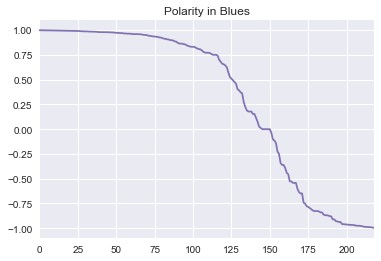

In [74]:
#Running for every genre
polarity_graph_generator(matches, 'genre')

## 2.3. Topic classification
Having the data divided in genres in important for our analysis, however we are still missing one key dimension to make our work relevant for social good: The topic that is adressed in the songs. We must be able to know which subject is dealt with in a song, and then we will aggregate the data for the genre and we will be able to understand how a particular genre is handling a specific topic. For this part we are still considering two options:

##### Option 1: Use the classifier from the 20newsgroup
The work that was done in the second part of Homework 4. The good point is that we have a tuned algorithm to classify text into 20 different classes with more than 85% of accuracy. It is very powerful but not the exact algorithm we are looking for. It provides a strict classification, putting a text into one precise class while we would rather have several tags for a particular music. Artists tend to treat several topics we writing a song, and the 20newsgroup classifier would limitate our data treatment.

Some data cleaning will be required if applying the 20newsgroup classifier. For instance categories dealing with computer science are likley to be irrelevant when classifying songs, thus why they will be taken away. 

##### Option 2: Find a deep learning algorithm/dataset that provides tags for songs
We are still exploring this possibility because option 1 does not provide the most appealing data we want. We have not encountered yet an algorithm that would provide a categorization with several tags. We are aware that we may not find such classifier, but since the 20newsgroup one is already fully implemented and ready to use (Tf-idf and RandomForest are coded. We will look for another option for as long as we can.


In the end, we opted for option 2
For each class label, we used www.thesaurus.com to find synonyms and related words. In addition to this, we added words that seemed relevant to us.
In order to have a strong classifier, we also used the extended dictionnary from google (COMPLETE WITH SOURCE AND EXACT NAME).

In [55]:
#import global vectors from stanfords pretrained set, trained on tweets, one can choose wished dim=25,50,100,200
global_vectors = HL.load_gensim_global_vectors(GS_200DIM)

#### Find the words that define the chosen topics

In [56]:
# Generating words from wordembedded vectors
gen_racism = HL.generate_related_words("racism", global_vectors, topn=10)
gen_women = HL.generate_related_words("women", global_vectors, topn=10)
gen_revolution = HL.generate_related_words("revolution", global_vectors, topn=10)
gen_money = HL.generate_related_words("racism", global_vectors, topn=10)
gen_politics = HL.generate_related_words("racism", global_vectors, topn=10)

In [57]:
#Defining the topics
racism = ['racism', 'nigger', 'negro', 'race', 'racist', 'bigot', 'bigotry', 'apartheid', 'discrimination', 'segregation', 'unfairness', 'partiality', 'sectarianism', 'colored']
women = ['women','girl', 'daughter', 'mother', 'she', 'wife', 'aunt', 'gentlewoman', 'girlfriend', 'grandmother', 'matron', 'niece', 'spouse', 'miss', 'genre']
money = ['money','bill', 'capital', 'cash', 'check', 'fund', 'pay', 'payment', 'property', 'salary', 'wage', 'wealth', 'banknote', 'bankroll', 'bread', 'bucks', 'chips', 'coin', 'coinage', 'dough', 'finances', 'funds', 'gold', 'gravy', 'greenback', 'loot', 'pesos', 'ressources', 'riches', 'roll', 'silver', 'specie', 'treasure', 'wad', 'wherewithal']
revolution = ['revolution','change', 'overthrow', 'demand', 'freedom', 'war', 'movement', 'brotherhood', 'reform', 'radical', 'leadership']
politics =  ['politics','campaigning','government','backroom','civics','electioneering','legislature','policy','political']

#### Create topic vectors so we can calculate a words similarity to topic

In [62]:
# make lists so one can iterate through the topics
name_of_topics = ['racism', 'women', 'money', 'revolution', 'politics']
own_topics = [racism,women,money,revolution, politics]
gen_topics = [gen_racism, gen_women, gen_money, gen_revolution, gen_politics]

# loop through the topics, create the topic, and group same topics in the same tuple
topic_vectors = []
for own, gen in zip(own_topics, gen_topics):
    gen_topic_vector = HL.create_topic(gen, global_vectors)
    own_topic_vector = HL.create_topic(own, global_vectors)
    topic_vectors.append((own_topic_vector, gen_topic_vector))

    
# example racism_ differnece of "related words to topic"
print("Example of difference in \"related words\":\n\ngenerated words:\n", gen_women)
print("Our picked words:\n", women)

Example of difference in "related words":

generated words:
 ['woman', 'men', 'girls', 'womens', 'ladies', 'females', 'female', 'they', 'people', 'these']
Our picked words:
 ['women', 'girl', 'daughter', 'mother', 'she', 'wife', 'aunt', 'gentlewoman', 'girlfriend', 'grandmother', 'matron', 'niece', 'spouse', 'miss', 'genre']


#### Calculate every words relation to the different topics

In [76]:
%%time
# maybe pickle the full_wordlist??
vocab_topics = full_word_list.copy(deep=True)
perc_dim_to_compare = 0.4


for topics, topic_name in zip(topic_vectors, name_of_topics):
    own_topic = topics[0]
    gen_topic = topics[1]
    print(topic_name)
    
    own_topic_scores = []
    gen_topic_scores = []
    for word in full_word_list.Word:
        own_topic_scores.append(HL.calculate_topic_similarity(word, own_topic[0],
                            global_vectors, std_dims=own_topic[1], perc_dim_to_compare=perc_dim_to_compare))
        gen_topic_scores.append(HL.calculate_topic_similarity(word, gen_topic[0],
                            global_vectors, std_dims=gen_topic[1], perc_dim_to_compare=perc_dim_to_compare))
    
    # give a suitable cloumnname
    own_columnname = "topic_own_" + topic_name
    gen_columnname = "topic_gen_" + topic_name
    vocab_topics[own_columnname] = pd.Series(own_topic_scores, index=full_word_list.index)
    vocab_topics[gen_columnname] = pd.Series(gen_topic_scores, index=full_word_list.index)
    

racism
women
money
revolution
politics
CPU times: user 15.5 s, sys: 818 ms, total: 16.3 s
Wall time: 17.3 s


#### Print out the dataframe and see the most relevant words for the topics

In [147]:
visual_vocab = vocab_topics.copy(deep=True)
display(visual_vocab.sort_values('topic_own_revolution',ascending=False).head(15))

,Word,Count,Occurence_percentage,Weight,topic_own_racism,topic_gen_racism,topic_own_women,topic_gen_women,topic_own_money,topic_gen_money,topic_own_revolution,topic_gen_revolution,topic_own_politics,topic_gen_politics
34143,revolution,27.0,0.000049,20430.864815,0.217293,0.236307,-0.108333,-0.122451,0.086933,0.236307,0.777882,0.783769,0.190043,0.236307
41651,radical,20.0,0.000036,27581.667500,0.387008,0.323122,-0.089670,-0.167777,-0.069533,0.323122,0.760550,0.603801,0.244369,0.323122
2962,movement,1108.0,0.002009,497.864034,0.326878,0.378146,-0.134344,-0.112289,0.289932,0.378146,0.759358,0.798550,0.271599,0.378146
10198,reform,175.0,0.000317,3152.190571,0.379197,0.359994,-0.231851,-0.109861,0.297174,0.359994,0.740659,0.594261,0.546388,0.359994
35786,leadership,25.0,0.000045,22065.334000,0.208903,0.357553,-0.060040,0.036478,0.211822,0.357553,0.735794,0.616319,0.436850,0.357553
381,war,18276.0,0.033131,30.183484,0.207346,0.186070,-0.108805,-0.090635,0.055400,0.186070,0.696769,0.667865,0.183498,0.186070
853,freedom,6122.0,0.011098,90.106722,0.184175,0.345407,-0.136169,-0.091953,0.236464,0.345407,0.675475,0.761174,0.141870,0.345407
10519,brotherhood,167.0,0.000303,3303.193713,0.311104,0.250842,0.052984,-0.152456,0.004262,0.250842,0.656698,0.503133,0.324936,0.250842
10038,overthrow,179.0,0.000324,3081.750559,0.448109,0.285034,-0.132810,-0.003071,0.106140,0.285034,0.644659,0.352279,0.426022,0.285034
43854,dictatorship,18.0,0.000033,30646.297222,0.393879,0.361414,-0.180212,-0.058294,0.179091,0.361414,0.618097,0.406614,0.440321,0.361414


#### Extrapolate from (word <-> topic)-relation to (song <-> topic)-relation

In [69]:
# dataframe with songs
#should pickle it as full_table_with_polarity maybe?
#matches = pd.read_pickle('full_table.pkl')

In [75]:
display(matches.head(4))

,Tid,Latitude,Longitude,Artist_Name,genre,Title,MXM_Tid,year,words_freq,Bags_of_words,Polarity_score
0,TRAAAAV128F421A322,37.77916,-122.42005,Western Addiction,Pop_Rock,A Poor Recipe For Civic Cohesion,4623710,2005,"[1:6, 2:4, 3:2, 4:2, 5:5, 6:3, 7:1, 8:1, 11:1,...",i i i i i i the the the the you yo...,0.7748
1,TRAAABD128F429CF47,35.14968,-90.04892,The Box Tops,Pop_Rock,Soul Deep,6477168,1969,"[1:10, 3:17, 4:8, 5:2, 6:2, 7:1, 8:3, 9:2, 10:...",i i i i i i i i i i you you you ...,0.9686
2,TRAAAEF128F4273421,35.83073,-85.97874,Adam Ant,Pop_Rock,Something Girls,3759847,1982,"[1:5, 2:4, 3:3, 4:2, 5:1, 6:11, 9:4, 12:9, 13:...",i i i i i the the the the you you ...,0.8689
3,TRAAAHJ128F931194C,39.74001,-104.99226,Devotchka,Pop_Rock,The Last Beat Of My Heart (b-side),5133845,2004,"[1:4, 2:11, 3:2, 4:7, 5:3, 6:5, 8:1, 9:3, 10:6...",i i i i the the the the the the the...,0.8720


In [135]:
def score_song(words_freq, vocab_topics, column):
    occurence_words_not_in_vocab = 0  # this variable Counts 'I' several times in just one song
    total_words_in_song = 0
    nr_words_per_song = 0
    column_score = 0
    for word_info in words_freq:
        [word_index, freq] = word_info.split(':')
        total_words_in_song += int(freq)
        try:
            word_score = vocab_topics.get_value(int(word_index),column)
            column_score += word_score*int(freq)
            nr_words_per_song += int(freq)
        except KeyError:
            occurence_words_not_in_vocab += int(freq)
    if nr_words_per_song is not 0:
        column_score = column_score/nr_words_per_song
    else:
        column_score = 'NaN'
    return column_score, occurence_words_not_in_vocab, total_words_in_song


def score_songs(songs_df, vocab_topics, column_startwith='topic'):
    """
    if songs have topic_category:
        save over or delete first
    else:
        create categories
    """
    
    #Fetch the columnnames of the topics
    column_names = [col for col in vocab_topics.columns if col.startswith(column_startwith)]

    #Applying the polarity analysis for the bags of words
    for column in column_names:
        occ_sum = 0
        tot_sum = 0
        for i in matches.index: 
            if np.all(score_song(matches.at[i, 'words_freq'], vocab_topics, column) != None):
                matches.at[i, column], occ, tot = score_song(matches.at[i, 'words_freq'], vocab_topics, column)
                occ_sum += occ
                tot_sum += tot
            #matches.at[i, topic] = analyser.polarity_scores(matches.at[i, 'Bags_of_words'])['compound']
    
    return occ_sum, tot_sum #songs_df_topics

occz, totz = score_songs(matches, vocab_topics)

In [145]:
print("Percentage of the songs that is not in the vocabulary: %.2f%%" % ((occz/totz)*100))


Percentage of the songs that is not in the vocabulary: 65.15%


In [151]:
visual_matches = matches.copy(deep=True)
display(visual_matches.sort_values('topic_gen_racism',ascending=False).head(15))

,Tid,Latitude,Longitude,Artist_Name,genre,Title,MXM_Tid,year,words_freq,Bags_of_words,...,topic_own_racism,topic_gen_racism,topic_own_women,topic_gen_women,topic_own_money,topic_gen_money,topic_own_revolution,topic_gen_revolution,topic_own_politics,topic_gen_politics
30110,TRUESDE128F427A589,34.05349,-118.24532,Tenacious D,Pop_Rock,Lee,775782,1999,"[1:2, 4:1, 5:4, 6:7, 7:2, 10:2, 13:1, 17:2, 18...",i i to and and and and a a a a a ...,...,0.101472,0.388930,-0.104743,0.078851,0.080447,0.388930,0.198048,0.199379,0.175656,0.388930
34890,TRXMRAF128F427FB0B,-34.60852,-58.37354,Luis Alberto Spinetta,Latin,Yo Quiero Ver Un Tren,5680536,1983,"[7:1, 174:1, 685:1, 1059:1]",me yo nunca imagin,...,0.159990,0.344175,-0.066799,-0.072093,-0.004346,0.344175,0.345411,0.248909,0.287958,0.344175
8686,TRFUOQY128F42621D4,34.05349,-118.24532,Tiger Army,Pop_Rock,Prelude: Nightfall,845290,1999,"[58:1, 97:1, 1833:1, 2508:1]",never die armi tiger,...,0.233950,0.323184,0.022174,-0.060042,0.117284,0.323184,0.358690,0.314301,0.242551,0.323184
10358,TRGZMYZ128F4240BA8,34.05349,-118.24532,Tiger Army,Pop_Rock,Prelude: Signal Return (Cd),6235274,2007,"[58:3, 97:3, 1833:3, 2508:3]",never never never die die die armi arm...,...,0.233950,0.323184,0.022174,-0.060042,0.117284,0.323184,0.358690,0.314301,0.242551,0.323184
5819,TRDXGPK128F1485ED8,40.71455,-74.00712,Janet Jackson,RnB,20 Part 2 (Interlude),5528460,2006,"[15:1, 37:1, 50:1, 2718:1]",that now out smooth,...,0.055223,0.317820,0.006943,0.131413,0.277512,0.317820,0.271894,0.167359,0.280273,0.317820
10362,TRGZOTU128E07946FD,51.37121,1.12510,Kevin Ayers,Pop_Rock,Beware Of The Dog (2003 Digital Remaster),2963801,1973,"[1:3, 3:2, 5:1, 9:1, 18:2, 20:1, 25:1, 34:1, 4...",i i i you you and not are are am be...,...,0.159768,0.292370,0.118562,0.295318,0.043960,0.292370,0.104329,0.173032,0.139368,0.292370
2473,TRBQXIA128EF35EF21,52.23974,-0.88576,Maps,Pop_Rock,Don't Fear,6092720,2007,"[2:12, 9:12, 16:12, 17:12, 36:12, 41:12, 61:12...",the the the the the the the the the ...,...,0.120063,0.286991,-0.002025,0.068703,0.136790,0.286991,0.190728,0.153400,0.171822,0.286991
12914,TRISWFP128E0782CF0,51.50632,-0.12714,David Bowie,Pop_Rock,Zeroes (1999 Digital Remaster),8346023,1987,[889:2],vie vie,...,0.215511,0.281204,-0.160494,-0.125926,0.196176,0.281204,0.355754,0.202722,0.220600,0.281204
30617,TRUNRWE128EF3553CD,42.67638,-76.82191,Enigma,New Age,Feel Me Heaven,5491326,2006,"[7:3, 61:3, 325:3, 3932:3]",me me me feel feel feel heaven heaven ...,...,-0.027947,0.276297,0.075121,-0.009971,0.000431,0.276297,0.209225,0.124500,0.137994,0.276297
21644,TRONUDL128F42978D0,40.02994,-6.08985,Extremoduro,Pop_Rock,Ni Principes Ni Princesas,3303797,1991,"[476:1, 2361:1, 2780:1]",s flor pobr,...,0.028904,0.275821,-0.090554,-0.065423,-0.117013,0.275821,0.198318,0.149503,0.182873,0.275821


## 3. Visualization: How to meaningfully represent the data
Now that we have the tools for a sentiment analysis, we must decide a way to visualize the results. Having a straightforward visualization will helop to compare the analyse features between genres, and this is precisely what we will try to achieve with the following visualization.

All the interactive visualization structure that we have here will be displayed in a blog. 

## 3.1. Topic-based approach
We first deal with polarity, then with lexical complexity.

### 3.1.1. Dealing with polarity
When having the topics and the polarity, we will be able to have an overview of how social topics are dealt with across music genres. We cannot draw any conclusion for this part without having every visual, but we believe that the comparison will provide a good insight on how music treats social topics.

Once every visualization will be generated, here is the representation structure that we want to have:

In [ ]:
display(Image(filename='Data/Organigram_polarity_viz.png'))

##### Description
- Each edge stands for a user's click.
- Rectangles are representing the barplot of polarity (for each genre/artist at the level)
- The user will pick a topic, this will display every genre treating the topic and their polarity barplot. Then when clicking on a genre's plot it will display what is polarity barplot for every artiss.


### 3.1.2. Dealing with complexity
We believe that there is a correlation between the complexity and the target audience. Has asserted earlier in this work, we do not have the sociological expertise to match the complextiy with precise social groups, but we assume that there is a correlation between the audience's age + educational level and the complexity of lyrics. 

We want to be able to visualize the complexity in two distinct ways. At first from a topic perspective by having genre displaying their complexity when treating a particular subject. Here is the display organigram we want to have:

In [ ]:
display(Image(filename='Data/Organigram_complexity_viz.png'))

##### Description
As before, edges stand for a user's click. Then when picking a genre, we will visualize what is the used lexical complexity. Comparing this value to this average of the genre will help to see if the target is more educated/older than the usual case for the genre.




The second visualization we want to provide is starting with topics on top. For every topic we want to be able to see the mean lexical complexity that is used by a genre to treat the topic. This will allow is to know what are the targeted audiences of each genres for a precise topic. Here is the data organigram:

In [ ]:
display(Image(filename='Data/Organigram_complexity_topic_viz.png'))

## 3.2. Data by location

We want to know what topic is adressed in each genre, and especially how is it spread accross the globe. For that we will use the location data that we gathered. We want to produce maps for:
- Complexity within a genre. In order to know how elaborate a genre is in different places around the world. We will use a heatmap to visualize the data.
- Polarity of genres when dealing with a certain topic. For instance we want to be able to know if a subject has a negative polarity in rock in the US while it is positive in the UK. 

## 3.3. Chronological progression
In order to know how a genre evolved, we want to plot the lexical complexity through time of every genre. We will use, again, a barplot. With the chronology on the x-axis an the complexity on the y-axis. 

# 4. Finalization: Organization of the outputs


## 4.1. 

##### Data handling
Due to the fact that we are solely treating text, and that the lyrics are not entirely given, we use a volume of data that is relatively small. This situation enables us to have the original text files stored on our machines, and proceeding to storage of value when using the notebook is not necessary since our computer's cache is big enough to treat our data.

##### Visualization
We are convinced that the barplot is the most fitting representation for the generated graphs. We might find another librairy that makes it look more visually appealing, but we believe that it is the most meaningful way to show our results.

##### Comparison
Once we will have a topic-based split of our data, we will be able to compare how topics are treated in different genres.

